## Importing Libraries and Tools

In [1]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageEnhance

#keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

## Loading Data

In [2]:
# Directories for training and testing data
train_dir = './Tumor Images/Training/'
test_dir = './Tumor Images/Testing/'

# load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

## Data Visualization

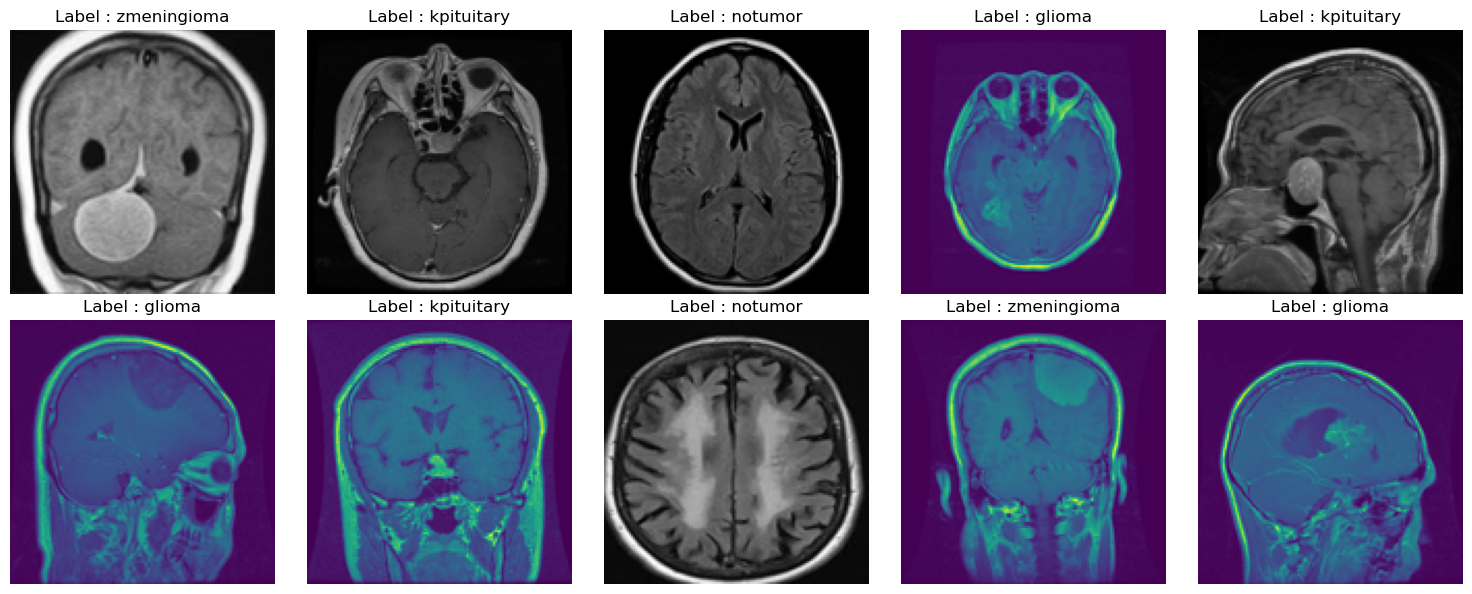

In [9]:
import matplotlib.pyplot as plt

# select 10 random indices for 10 images
random_indices = random.sample(range(len(train_paths)),10)

# create a figure to display images in 2 rows
fig, axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.ravel()

# loop through random indices and display images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))

    # display images
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label : {train_labels[idx]}")

plt.tight_layout()
plt.show()

## Image Augmentation

In [3]:
# Data augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = img_to_array(image) / 255.0     # normalize pixel values to [0, 1]
    return image

# load image and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)     

# image encoding (convert label names to integer)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)                                # ensuring only unique labels determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_images = open_images(batch_paths)     # open and augment images
            
            batch_labels = labels[i:i+batch_size]
            batch_labels = encode_label(batch_labels)   # encode labels
            
            yield batch_images, batch_labels            # yield the batch

## Building Model

In [5]:
# model architecture (128, 128, 3)
IMAGE_SIZE = 128
base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build Model
model = Sequential()
model.add(Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))  # input layer
model.add(base_model) # VGG16 model
model.add(Flatten()) # flatten layer
model.add(Dropout(0.3)) # dropout layer

model.add(Dense(128, activation='relu')) # dense layer
model.add(Dropout(0.2)) # dropout layer

model.add(Dense(4, activation='softmax')) # output layer

# compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# parameters
batch_size = 20
steps = max(1, len(train_paths) // batch_size)
epochs = 5

# train model
history = model.fit(
    datagen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),
    epochs = epochs,
    steps_per_epoch = steps
)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8335
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - loss: 0.2184 - sparse_categorical_accuracy: 0.9180
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - loss: 0.1381 - sparse_categorical_accuracy: 0.9492
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 4836s 17s/step - loss: 0.1003 - sparse_categorical_accuracy: 0.9631
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - loss: 0.0783 - sparse_categorical_accuracy: 0.9712


## Train and Validation plot

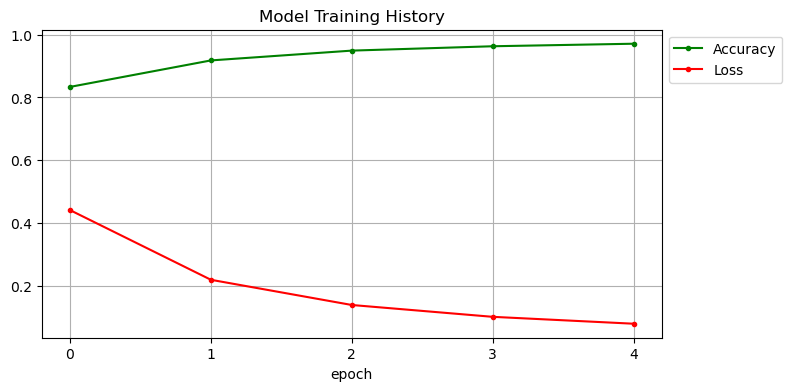

In [6]:
plt.figure(figsize = (8, 4))
plt.grid(True)
plt.plot(history.history["sparse_categorical_accuracy"], ".g-")
plt.plot(history.history["loss"], ".r-")
plt.title("Model Training History")
plt.xlabel("epoch")
plt.xticks([x for x in range(epochs)])
plt.legend(["Accuracy", "Loss"], loc = "upper left", bbox_to_anchor = (1, 1))
plt.show()

## Model Classification Report

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report: ")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis = 1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       300
           1       0.96      0.88      0.92       306
           2       0.99      0.99      0.99       405
           3       1.00      0.96      0.98       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.95      0.96      1311



## Confusion Matrix

Confusion Matrix: 
[[295   5   0   0]
 [ 31 268   6   1]
 [  5   0 400   0]
 [  5   6   0 289]]


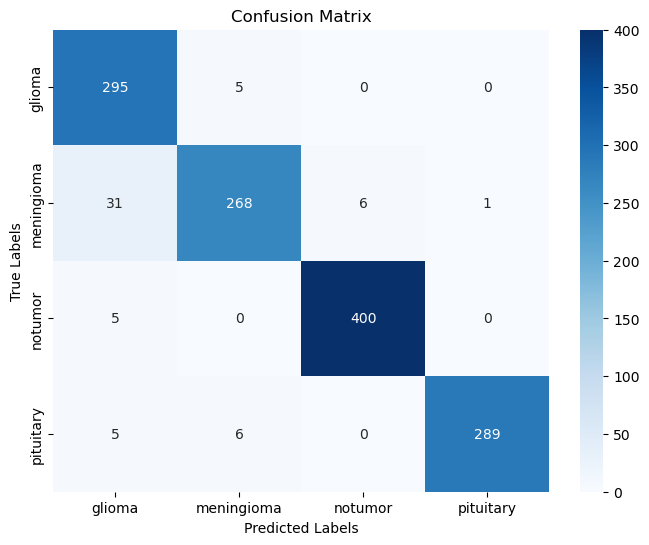

In [8]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis = 1))
print("Confusion Matrix: ")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = os.listdir(train_dir), yticklabels = os.listdir(train_dir))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## ROC Curve

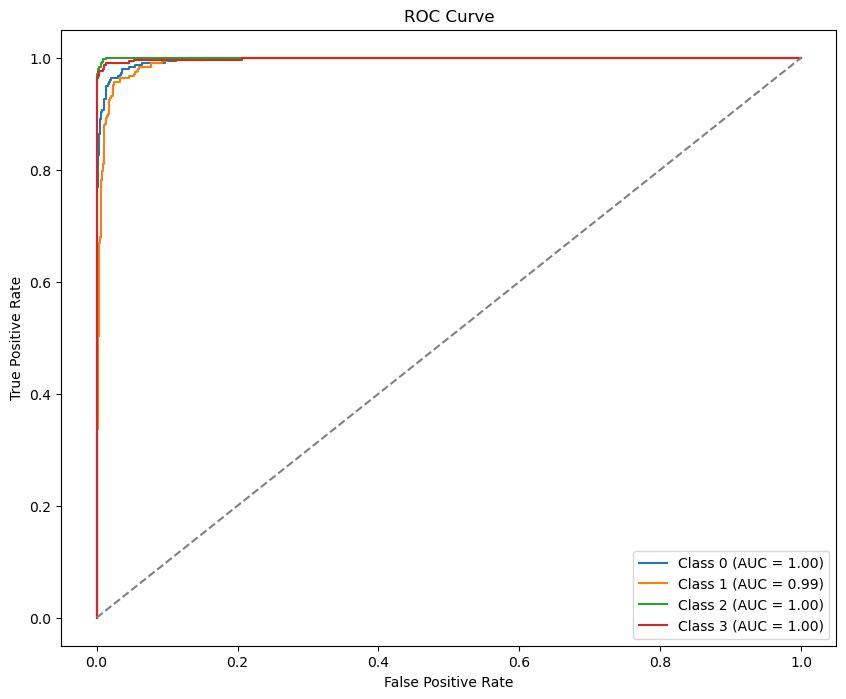

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os

# Binarize labels
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # predicted probabilities for each class

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
n_classes = len(os.listdir(train_dir))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves together (outside the loop!)
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Save & Load Model

In [46]:
model.save("model.h5")
model.save("model.keras")

In [4]:
from tensorflow.keras.models import load_model
# load the trained model
model = load_model("model.h5")

## MRI Tumor Detection System

In [5]:
from keras.preprocessing.image import load_img, img_to_array

class_labels = ["glioma", "meningioma", "notumor", "pituitary"]

def detect_and_display(image_path, model):
  try:
    # load image
    image = load_img(image_path, target_size = (128, 128))
    image_array = img_to_array(image)
    image_array = augment_image(image_array)
    image_array = np.expand_dims(image_array, axis = 0)     # while model training, batches are given and here only one image is given so have to expand dimension

    # prediction
    prediction = model.predict(image_array)
    predicted_class_index = np.argmax(prediction)
    confidence_score = np.max(prediction, axis = 1)[0]

    # determine the class
    if class_labels[predicted_class_index] == "notumor":
      result =  "No Tumor"

    else:
      result = f"Tumor: {class_labels[predicted_class_index]}"

    # disply result
    plt.imshow(load_img(image_path))
    plt.axis("off")
    plt.title(f"{result} (Confidence:) {confidence_score * 100:.2f}%")
    plt.show()

  except Exception as e:
    print("Error in processing the image: ", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


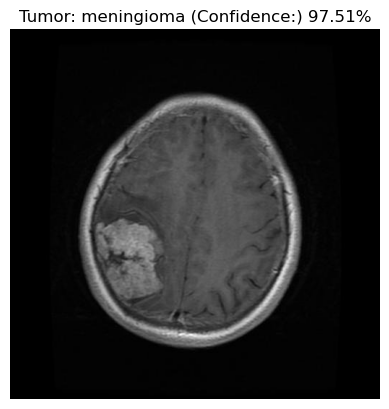

In [ ]:
# example usage
image_path = "./Tumor Images/Testing/meningioma/Te-meTr_0001.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


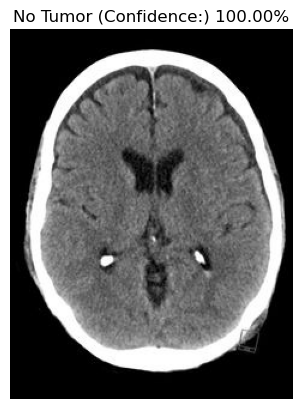

In [12]:
image_path = "./Tumor Images/Testing/notumor/Te-no_0051.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


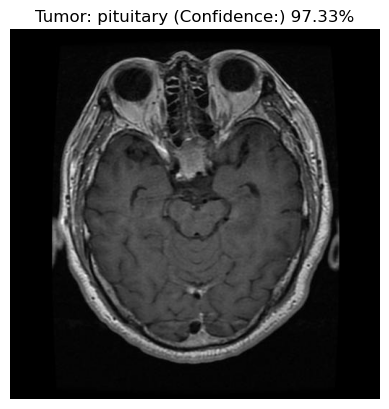

In [51]:
image_path = "./Tumor Images/Testing/pituitary/Te-pi_0031.jpg"
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


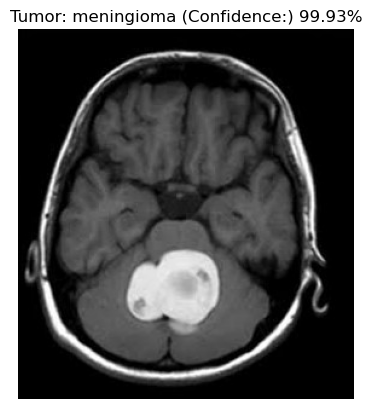

In [52]:
image_path = "./Tumor Images/Testing/meningioma/Te-me_0029.jpg"
detect_and_display(image_path, model)